In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import networkx as nx
import itertools
import torch
import os

import scipy.stats

import tsvar
from tsvar.preprocessing import Dataset
import experiments_utils

Set cells width

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

---

## Load the dataset

Set input path

In [4]:
INPUT_PATH = "../../data/email-Eu-core-temporal.txt.gz"

Load the dataset

In [5]:
dataset = Dataset(INPUT_PATH, top=100, timescale='median')

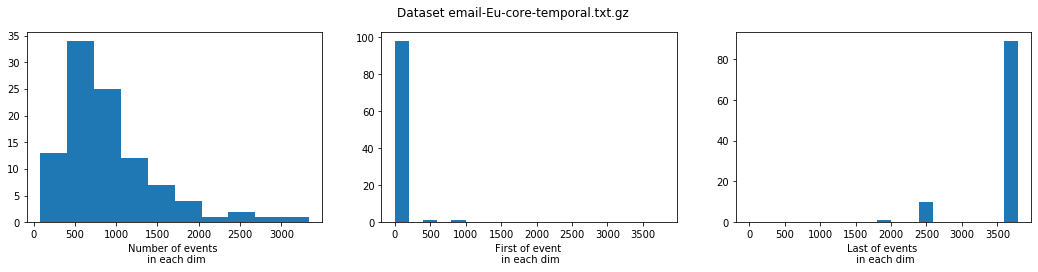

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

axs[0].hist(list(map(len, dataset.timestamps)))
axs[0].set_xlabel('Number of events \n in each dim')

end_time = dataset.end_time
axs[1].hist(list(map(min, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[1].set_xlabel('First of event \n in each dim')

axs[2].hist(list(map(max, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[2].set_xlabel('Last of events \n in each dim')

fig.suptitle(f"Dataset {os.path.split(INPUT_PATH)[1]}");

Print statistics of the dataset

In [7]:
print(f"Num. of dimensions: {len(dataset.timestamps):,d}")
print(f"    Num. of events: {sum(map(len, dataset.timestamps)):,d}")
print(f"               %NZ: {100 * dataset.graph.number_of_edges() / (dataset.graph.number_of_nodes() ** 2):.2f}%")
print()
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, dataset.timestamps)))
print(pd.Series(num_jumps_per_dim).describe())

Num. of dimensions: 100
    Num. of events: 92,924
               %NZ: 26.23%

Stats. of num. of events per dim:
count     100.000000
mean      929.240000
std       589.331261
min        82.000000
25%       544.000000
50%       770.000000
75%      1210.000000
max      3334.000000
dtype: float64


#### Visualize the scale of time using empirical inter-arrival time distributions

Compute this for both definitions $\{\beta_j\}$ and $\{\beta_{ij}\}$.

Busca estimators of **beta_j**:
count    100.000000
mean       1.047821
std        1.697593
min        0.027073
25%        0.290703
50%        0.556093
75%        0.916578
max       13.945126
dtype: float64
Median: 0.5560928243605474


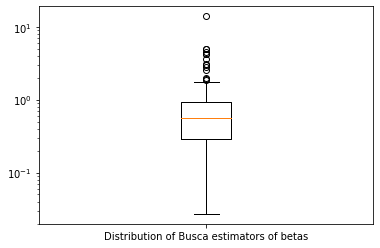

In [8]:
busca_betas = np.array([np.median(np.hstack((ev[0], np.diff(ev)))) for ev in dataset.timestamps])
plt.boxplot(busca_betas, labels=['Distribution of Busca estimators of betas']);
plt.yscale('log')
print('Busca estimators of **beta_j**:')
print(pd.Series(busca_betas.flatten()).describe())
print('Median:', np.median(busca_betas))

Busca estimators of **beta_{ij}**:
count    10000.000000
mean         1.218508
std          2.322191
min          0.000000
25%          0.344152
50%          1.004831
75%          1.474058
max        118.573898
dtype: float64
Median: 1.0048314332962036


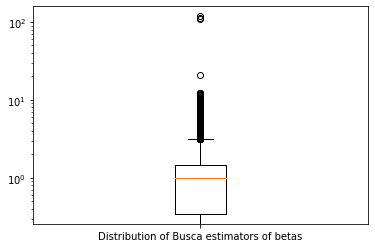

In [9]:
wold_model = tsvar.models.WoldModel()
wold_model.observe(dataset.timestamps)
busca_beta_ji = np.zeros((wold_model.dim, wold_model.dim))
for i in range(wold_model.dim):
    busca_beta_ji[:, i] = np.median(wold_model.delta_ikj[i][:, :], axis=0) / np.exp(1)
del wold_model

plt.boxplot(busca_beta_ji.flatten(), labels=['Distribution of Busca estimators of betas']);
plt.yscale('log')
print('Busca estimators of **beta_{ij}**:')
print(pd.Series(busca_beta_ji.flatten()).describe())
print('Median:', np.median(busca_beta_ji))

Build ground truth adjacency matrix

In [10]:
adjacency_true = nx.adjacency_matrix(dataset.graph, nodelist=range(dataset.dim)).toarray()
adjacency_true = adjacency_true / adjacency_true.max()

In [11]:
events = dataset.timestamps
end_time = dataset.end_time

---

## Run inference

---

### Run BBVI

In [ ]:
dim = len(events)
n_params = dim + dim**2 + dim**2
end_time = max(map(max, events))

# Set initial guess
coeffs_start = torch.tensor(np.hstack((
    # loc
    -2.0 * torch.ones(dim, dtype=torch.float),                  # baseline
    0.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # beta
    0.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # adjacency
    # scale
    torch.log(0.2 * torch.ones(dim, dtype=torch.float)),
    torch.log(0.2 * torch.ones((dim, dim), dtype=torch.float).flatten()),
    torch.log(0.2 * torch.ones((dim, dim), dtype=torch.float).flatten()),
)))

# Define priors/posteriors
posterior = tsvar.posteriors.LogNormalPosterior
prior = tsvar.priors.GaussianLaplacianPrior
mask_gaus = torch.zeros(n_params, dtype=torch.bool)
mask_gaus[:dim + dim**2] = 1  # Gaussian prior for baseline and beta
C = 1e3

# Init the model object
model = tsvar.models.WoldModelBBVI(posterior=posterior, prior=prior, C=C,
                                   prior_kwargs={'mask_gaus': mask_gaus},
                                   n_samples=1, n_weights=1, weight_temp=1,
                                   verbose=False, device='cpu')
model.observe(events, end_time)

# Set link function for callback (vi coeffs -> posterior mode)
def link_func(coeffs):
    """variationa coeffs -> posterior mode of adjacency"""
    # Numpy to torch
    coeffs = torch.tensor(coeffs) if isinstance(coeffs, np.ndarray) else coeffs
    return model.posterior.mode(
        coeffs[:model.n_params], coeffs[model.n_params:]
    ).detach().numpy()[dim:dim+dim**2]

# Set the callback (callback parameters are posterior mode)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=posterior().mode(
        coeffs_start[:dim+2*dim**2], coeffs_start[dim+2*dim**2:]
    )[dim:dim+dim**2],
    print_every=10,
    coeffs_true=adjacency_true,
    acc_thresh=0.05,
    dim=dim,
    link_func=link_func,
    default_end='\n')

# Fit the model
conv = model.fit(x0=coeffs_start, optimizer=torch.optim.Adam, lr=1e-1,
                 lr_sched=0.9999, tol=1e-6, max_iter=20000,
                 mstep_interval=100, mstep_offset=500, mstep_momentum=0.5,
                 seed=None, callback=callback)

In [ ]:
coeffs_hat = model.posterior.mode(model.coeffs[:n_params], model.coeffs[n_params:])
beta_hat = coeffs_hat[dim:dim+dim**2]
adj_hat = coeffs_hat[dim+dim**2:]

In [ ]:
sum(adj_hat >= THRESH)

In [ ]:
coeffs_hat = model.posterior.mode(model.coeffs[:n_params], model.coeffs[n_params:]).detach().numpy()
beta_hat = coeffs_hat[dim:dim+dim**2]
adj_hat = coeffs_hat[dim+dim**2:]

adj_hat = adj_hat / beta_hat

THRESH = 0.01

acc = tsvar.utils.metrics.accuracy(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    threshold=THRESH)
fsc = tsvar.utils.metrics.fscore(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    threshold=THRESH)
relerr = tsvar.utils.metrics.relerr(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten())
precat5 = tsvar.utils.metrics.precision_at_n(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    n=5)
precat10 = tsvar.utils.metrics.precision_at_n(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    n=10)
precat20 = tsvar.utils.metrics.precision_at_n(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    n=20)

prec = tsvar.utils.metrics.precision(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    threshold=THRESH)
rec = tsvar.utils.metrics.recall(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    threshold=THRESH)

print(f"Accuracy: {acc:.2f}")
print(f"F1-Score: {fsc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"Prec@5: {precat5:.2f}")
print(f"Prec@10: {precat10:.2f}")
print(f"Prec@20: {precat20:.2f}")

print()
for k in [5, 10, 20]:
    print(k, tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat >= THRESH, A_true=adjacency_true, k=k))

---

### Run VI-fb

In [22]:
dim = len(events)

# Set priors
as_pr = 10.0 * np.ones((dim + 1, dim))
ar_pr = 10.0 * np.ones((dim + 1, dim))

zc_pr = [1.0 * np.ones((len(ev), dim+1)) for ev in events]

beta = 1.0 * np.ones((dim, dim))
#beta = busca_beta_ji

In [23]:
# Set model
vifb_model = tsvar.models.WoldModelVariationalFixedBeta(verbose=True)
vifb_model.observe(events, beta=busca_beta_ji)

In [24]:
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr / ar_pr).flatten(), print_every=10,
    coeffs_true=adjacency_true.flatten(),
    acc_thresh=0.05, dim=dim, 
    widgets={'f1score', 'relerr', 'prec@5', 'prec@10', 'prec@20'},
    default_end='\n')

# Fit model
conv = vifb_model.fit(as_pr=as_pr, ar_pr=ar_pr, zc_pr=zc_pr, max_iter=5000,
                 tol=1e-5, callback=callback)
print('Converged?', conv)

iter:    10 | dx: +3.9583e-02 | f1-score: 0.12 | relerr: 6.63e+01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.05 | time/it: 2.39e-01     
iter:    20 | dx: +5.1465e-03 | f1-score: 0.12 | relerr: 6.61e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.05 | time/it: 2.30e-01     
iter:    30 | dx: +7.7139e-04 | f1-score: 0.12 | relerr: 6.61e+01 | p@5: 0.20 | p@10: 0.10 | p@20: 0.05 | time/it: 2.32e-01     
iter:    40 | dx: +3.7225e-04 | f1-score: 0.12 | relerr: 6.61e+01 | p@5: 0.20 | p@10: 0.10 | p@20: 0.05 | time/it: 2.28e-01     
iter:    50 | dx: +1.8002e-04 | f1-score: 0.12 | relerr: 6.61e+01 | p@5: 0.20 | p@10: 0.10 | p@20: 0.05 | time/it: 2.29e-01     
iter:    60 | dx: +9.2204e-05 | f1-score: 0.12 | relerr: 6.61e+01 | p@5: 0.20 | p@10: 0.10 | p@20: 0.05 | time/it: 2.29e-01     
iter:    70 | dx: +4.7154e-05 | f1-score: 0.12 | relerr: 6.61e+01 | p@5: 0.20 | p@10: 0.10 | p@20: 0.05 | time/it: 2.29e-01     
iter:    80 | dx: +2.8742e-05 | f1-score: 0.12 | relerr: 6.61e+01 | p@5: 0.20 | p@10: 0.10 | p@20

KeyboardInterrupt: 

In [34]:
adj_hat_mode = (vifb_model._as_po[1:, :] - 1) / vifb_model._ar_po[1:, :] 
adj_hat_mode[adj_hat_mode < 0] = 0

adj_hat_mean = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]

adj_hat_std = np.sqrt(vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :] ** 2)

#adj_hat = adj_hat_mean / adj_hat_std
adj_hat = adj_hat_mean
#adj_hat = adj_hat_mode

experiments_utils.print_report(adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.05)

Accuracy: 0.67

Edge counts
------------
Pred: 1072.00
True: 2623.00

Error counts
------------
 True Positive: 214.00
False Positive: 858.00
 True Negative: 6519.00
False Negative: 2409.00

Error rates
-----------
 True Positive Rate: 0.08
False Positive Rate: 0.12
 True Negative Rate: 0.88
False Negative Rate: 0.92

F-Score
-------
 F1-Score: 0.12
Precision: 0.20
   Recall: 0.08

Precision@k
-----------
 Prec@5: 0.20
Prec@10: 0.10
Prec@20: 0.05

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.16363636363636352
10 0.24747474747474738
20 0.3156565656565658



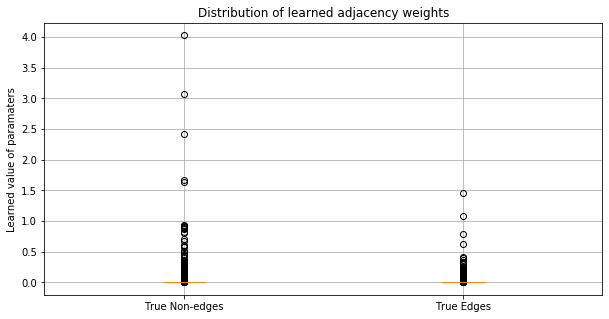

In [39]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.boxplot(
    [
        adj_hat[adjacency_true == 0.0], 
        adj_hat[adjacency_true > 0.0]
    ],
    labels=[
        'True Non-edges',
        'True Edges'
    ])
plt.ylabel(r'Learned value of paramaters')
plt.title('Distribution of learned adjacency weights');

---

### Run VI

In [18]:
dim = len(events)

# Set priors
# prior: Alpha
as_pr = 0.1 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 10.0 * np.ones((dim, dim))
br_pr = 10.0 * np.ones((dim, dim))

# prior: Z
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

print('ALPHA:')
print('------')
print('mean')
print(as_pr[0,0] / ar_pr[0,0])
print('variance')
print(as_pr[0,0] / ar_pr[0,0] ** 2)

print('BETA:')
print('-----')
print('mean')
print(br_pr[0,0] / (bs_pr[0,0] - 1))
print('variance')
print(br_pr[0,0]**2 / ((bs_pr[0,0] - 1)**2 * (bs_pr[0,0] - 2)))

ALPHA:
------
mean
0.1
variance
0.1
BETA:
-----
mean
1.1111111111111112
variance
0.15432098765432098


In [19]:
# Set model & observations
vi_model = tsvar.models.WoldModelVariational(verbose=True)
vi_model.observe(events)

In [20]:
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr[1:,:] / ar_pr[1:,:]).flatten(), print_every=1,
    coeffs_true=adjacency_true.flatten(),
    acc_thresh=0.05, dim=dim, 
    widgets={'f1score', 'relerr', 'prec@5', 'prec@10', 'prec@20'},
    default_end='\n')

# Fit model
vi_model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
          max_iter=2500, tol=1e-5, callback=callback)

################################################## iter: 0
---- Alpha
as:
[ 9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74
  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74  9.74]
ar:
[ 3784.40  1911.57  1977.28  1932.67  1004.79  2331.30  2290.02  1015.27  1930.81  1431.23  2262.23   930.37  1389.73  1971.26   700.46  1263.12  2012.59  2389.97  2269.33  1592.49  1094.39  2151.28   811.67  2227.89   918.18  2132.36  1555.39   912.61  2151.40  1175.14  1606.82  2072.41  2110.66   842.06  1990.

---- Beta
x0:
[[ 0.98  1.18  0.88 ...  0.97  1.02  1.00]
 [ 0.78  1.12  0.92 ...  0.92  0.98  0.88]
 [ 0.81  0.99  0.90 ...  0.95  0.97  0.80]
 ...
 [ 0.85  0.96  0.89 ...  0.90  0.89  0.90]
 [ 0.83  0.89  0.90 ...  0.95  0.89  0.87]
 [ 1.11  0.98  0.89 ...  0.96  0.97  0.85]]
xn:
[[ 1.27  1.55  1.20 ...  1.64  1.46  1.59]
 [ 0.95  1.43  1.28 ...  1.48  1.38  1.27]
 [ 1.07  1.43  1.19 ...  1.66  1.50  1.16]
 ...
 [ 1.09  1.28  1.30 ...  1.29  1.30  1.26]
 [ 1.01  1.12  1.27 ...  1.59  1.17  1.14]
 [ 1.68  1.19  1.18 ...  1.68  1.36  1.00]]
bs:
[ 14.30  14.39  12.27  15.49  16.07  15.21  15.89  16.16  12.43  14.29  24.98  18.15  15.40  15.26  17.88  14.75  15.13  13.57  13.92  18.90  16.14  16.93  14.57  20.74  15.17  19.69  20.27  13.51  15.57  12.18  14.30  12.04  13.20  11.98  16.14  20.75  15.65  12.59  11.09  11.74  14.67  13.24  15.61  12.36  14.93  12.41  16.34  14.22  12.22  16.41  12.70  13.78  19.46  12.55  14.76  11.93  14.91
  12.00  12.55  11.98  12.69  13.28  15.28  15.11 

zp:
[[ 1.00  0.00  0.00 ...  0.00  0.00  0.00]
 [ 0.02  0.00  0.00 ...  0.00  0.00  0.00]
 [ 0.02  0.00  0.00 ...  0.00  0.00  0.00]
 ...
 [ 0.03  0.01  0.01 ...  0.02  0.00  0.00]
 [ 0.03  0.01  0.01 ...  0.02  0.00  0.00]
 [ 0.03  0.01  0.01 ...  0.02  0.00  0.00]]
iter:     5 | dx: +1.3281e-01 | f1-score: 0.03 | relerr: 2.24e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 1.38e+00     
################################################## iter: 5
---- Alpha
as:
[ 18.47   5.47   5.43   0.95  12.58   6.60   4.36  15.37  10.60   2.52   3.03  65.00  22.41   7.86  16.43  25.98   5.27   3.94   1.81   4.76  21.15   8.67  23.52   3.33  42.66   5.21  23.88  53.41   1.47  11.27   1.39   3.90   0.35   4.68   0.41  11.45  27.58  12.34   0.82   0.18   0.35   3.89   1.27   9.94   1.28  16.68   2.19  12.81   2.45   1.21  12.39   1.04   3.16  33.44   2.40  22.83   0.53
   6.39   3.68   0.79   0.41   1.72   3.58  12.55   9.04   5.12   0.82  14.66  12.38  12.14  22.25  16.74   4.89   1.63   5.46  1

################################################## iter: 7
---- Alpha
as:
[ 18.41   3.28   3.21   0.15  10.39   4.20   2.25  14.61   8.20   0.89   1.24  95.65  23.97   5.31  16.15  30.27   2.93   1.99   0.49   2.60  21.11   6.36  25.01   1.44  53.93   2.81  26.49  72.53   0.32   9.01   0.30   1.87   0.10   2.51   0.10   8.79  31.98   9.92   0.13   0.10   0.10   1.86   0.25   7.73   0.25  16.05   0.75  10.70   0.87   0.23  10.45   0.18   1.36  41.92   0.82  24.01   0.10
   3.88   1.71   0.12   0.10   0.46   1.59  10.45   6.56   2.76   0.13  13.06  10.40  10.15  23.00  15.71   2.59   0.39   3.24   8.86  19.82   0.11   7.91   0.10   0.11  31.24  21.86   0.10   0.18   0.11   0.15   0.10   0.10   0.10   4.68   0.10  12.96   0.95  35.25   0.10   0.10  88.25   3.11   2.74   0.10]
ar:
[ 3784.40  1900.83  1956.34  1911.27  1050.29  2328.75  2256.99  1033.99  2012.53  1427.25  2217.77  1158.32  1511.59  2042.11   735.14  1428.49  2026.95  2351.34  2235.61  1612.70   986.17  2161.36   857.26  219

################################################## iter: 9
---- Alpha
as:
[  17.72    1.70    1.62    0.10    7.98    2.37    0.90   13.33    5.94    0.17    0.30  120.51   24.25    3.27   15.31   33.61    1.35    0.76    0.10    1.17   19.52    4.35   24.98    0.40   61.33    1.23   28.12   88.07    0.10    6.73    0.10    0.65    0.10    1.09    0.10    6.20   35.18    7.43    0.10    0.10    0.10    0.64    0.10    5.66    0.10   14.74    0.14    8.34    0.16
    0.10    8.34    0.10    0.36   49.57    0.15   23.74    0.10    2.03    0.56    0.10    0.10    0.10    0.47    8.19    4.42    1.22    0.10   11.00    8.22    8.01   22.33   13.89    1.11    0.10    1.65    6.40   18.69    0.10    4.71    0.10    0.10   34.39   21.17    0.10    0.10    0.10    0.10    0.10    0.10    0.10    2.87    0.10   11.39    0.19   40.00    0.10    0.10  105.68
    1.49    1.33    0.10]
ar:
[ 3784.40  1903.40  1963.36  1920.49  1041.57  2326.16  2268.56  1034.13  1991.56  1426.26  2239.24  1227.98  

################################################## iter: 11
---- Alpha
as:
[  16.97    0.66    0.60    0.10    5.84    1.11    0.19   11.98    4.11    0.10    0.10  136.90   23.96    1.80   14.37   36.61    0.41    0.15    0.10    0.32   17.42    2.77   24.31    0.10   65.95    0.33   29.43  100.40    0.10    4.79    0.10    0.12    0.10    0.28    0.10    4.09   37.94    5.34    0.10    0.10    0.10    0.12    0.10    3.95    0.10   13.27    0.10    6.23    0.10
    0.10    6.45    0.10    0.10   57.07    0.10   22.87    0.10    0.83    0.11    0.10    0.10    0.10    0.10    6.23    2.78    0.33    0.10    9.04    6.27    6.10   21.15   11.97    0.28    0.10    0.61    4.36   17.23    0.10    2.46    0.10    0.10   36.96   19.96    0.10    0.10    0.10    0.10    0.10    0.10    0.10    1.56    0.10    9.83    0.10   44.36    0.10    0.10  117.46
    0.49    0.43    0.10]
ar:
[ 3784.40  1903.24  1966.09  1920.51  1032.04  2322.35  2273.42  1032.83  1971.90  1425.84  2246.82  1280.52 

################################################## iter: 13
---- Alpha
as:
[  16.24    0.13    0.12    0.10    4.07    0.31    0.10   10.63    2.66    0.10    0.10  145.71   23.37    0.77   13.41   39.46    0.10    0.10    0.10    0.10   15.21    1.56   23.33    0.10   68.75    0.10   30.59  110.11    0.10    3.19    0.10    0.10    0.10    0.10    0.10    2.47   40.48    3.64    0.10    0.10    0.10    0.10    0.10    2.58    0.10   11.78    0.10    4.44    0.10
    0.10    4.83    0.10    0.10   64.53    0.10   21.71    0.10    0.17    0.10    0.10    0.10    0.10    0.10    4.58    1.54    0.10    0.10    7.28    4.60    4.47   19.77   10.13    0.10    0.10    0.12    2.76   15.66    0.10    1.04    0.10    0.10   39.13   18.51    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.62    0.10    8.36    0.10   48.31    0.10    0.10  125.43
    0.10    0.10    0.10]
ar:
[ 3784.40  1902.34  1966.92  1920.51  1023.57  2318.71  2274.67  1031.00  1955.72  1425.84  2247.11  1317.61 

################################################## iter: 15
---- Alpha
as:
[  15.58    0.10    0.10    0.10    2.64    0.10    0.10    9.33    1.52    0.10    0.10  149.61   22.63    0.17   12.45   42.29    0.10    0.10    0.10    0.10   13.07    0.65   22.21    0.10   70.59    0.10   31.65  117.99    0.10    1.92    0.10    0.10    0.10    0.10    0.10    1.27   42.95    2.30    0.10    0.10    0.10    0.10    0.10    1.48    0.10   10.32    0.10    2.98    0.10
    0.10    3.44    0.10    0.10   71.97    0.10   20.46    0.10    0.10    0.10    0.10    0.10    0.10    0.10    3.21    0.63    0.10    0.10    5.73    3.18    3.09   18.37    8.42    0.10    0.10    0.10    1.52   14.08    0.10    0.25    0.10    0.10   41.02   16.95    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.13    0.10    7.01    0.10   51.77    0.10    0.10  131.29
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1016.49  2316.43  2274.68  1029.03  1942.49  1425.84  2247.11  1342.92 

################################################## iter: 17
---- Alpha
as:
[  14.98    0.10    0.10    0.10    1.50    0.10    0.10    8.08    0.64    0.10    0.10  150.73   21.79    0.10   11.49   45.13    0.10    0.10    0.10    0.10   11.07    0.14   21.02    0.10   71.93    0.10   32.63  124.57    0.10    0.93    0.10    0.10    0.10    0.10    0.10    0.43   45.38    1.24    0.10    0.10    0.10    0.10    0.10    0.63    0.10    8.93    0.10    1.79    0.10
    0.10    2.27    0.10    0.10   79.28    0.10   19.19    0.10    0.10    0.10    0.10    0.10    0.10    0.10    2.07    0.13    0.10    0.10    4.36    2.01    1.94   16.98    6.87    0.10    0.10    0.10    0.62   12.53    0.10    0.10    0.10    0.10   42.68   15.36    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    5.76    0.10   54.74    0.10    0.10  135.98
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1010.72  2316.29  2274.68  1027.06  1931.77  1425.84  2247.11  1359.81 

################################################## iter: 19
---- Alpha
as:
[  14.42    0.10    0.10    0.10    0.62    0.10    0.10    6.87    0.14    0.10    0.10  150.30   20.86    0.10   10.53   47.94    0.10    0.10    0.10    0.10    9.21    0.10   19.79    0.10   72.95    0.10   33.49  130.05    0.10    0.25    0.10    0.10    0.10    0.10    0.10    0.10   47.74    0.45    0.10    0.10    0.10    0.10    0.10    0.13    0.10    7.59    0.10    0.85    0.10
    0.10    1.28    0.10    0.10   86.20    0.10   17.91    0.10    0.10    0.10    0.10    0.10    0.10    0.10    1.12    0.10    0.10    0.10    3.16    1.05    1.00   15.61    5.45    0.10    0.10    0.10    0.13   11.01    0.10    0.10    0.10    0.10   44.09   13.76    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    4.61    0.10   57.15    0.10    0.10  139.80
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1006.08  2316.29  2274.68  1025.13  1923.79  1425.84  2247.11  1370.77 

################################################## iter: 21
---- Alpha
as:
[  13.86    0.10    0.10    0.10    0.13    0.10    0.10    5.71    0.10    0.10    0.10  149.06   19.82    0.10    9.55   50.59    0.10    0.10    0.10    0.10    7.50    0.10   18.52    0.10   73.71    0.10   34.16  134.52    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   49.93    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    6.32    0.10    0.21    0.10
    0.10    0.50    0.10    0.10   92.40    0.10   16.62    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.39    0.10    0.10    0.10    2.10    0.33    0.31   14.24    4.15    0.10    0.10    0.10    0.10    9.52    0.10    0.10    0.10    0.10   45.19   12.16    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    3.54    0.10   59.01    0.10    0.10  142.91
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1002.73  2316.29  2274.68  1023.23  1921.25  1425.84  2247.11  1377.73 

################################################## iter: 23
---- Alpha
as:
[  13.32    0.10    0.10    0.10    0.10    0.10    0.10    4.61    0.10    0.10    0.10  147.48   18.71    0.10    8.58   53.04    0.10    0.10    0.10    0.10    5.95    0.10   17.22    0.10   74.30    0.10   34.65  138.20    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   51.93    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    5.12    0.10    0.10    0.10
    0.10    0.11    0.10    0.10   97.76    0.10   15.34    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    1.19    0.10    0.10   12.88    2.99    0.10    0.10    0.10    0.10    8.07    0.10    0.10    0.10    0.10   46.03   10.61    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    2.55    0.10   60.36    0.10    0.10  145.52
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1021.37  1921.24  1425.84  2247.11  1381.99 

################################################## iter: 25
---- Alpha
as:
[  12.82    0.10    0.10    0.10    0.10    0.10    0.10    3.57    0.10    0.10    0.10  145.99   17.56    0.10    7.62   55.35    0.10    0.10    0.10    0.10    4.56    0.10   15.95    0.10   74.86    0.10   35.00  141.41    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   53.80    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    4.01    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  102.36    0.10   14.09    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.45    0.10    0.10   11.55    1.96    0.10    0.10    0.10    0.10    6.70    0.10    0.10    0.10    0.10   46.70    9.12    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    1.65    0.10   61.38    0.10    0.10  147.94
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1019.54  1921.24  1425.84  2247.11  1384.40 

################################################## iter: 27
---- Alpha
as:
[  12.36    0.10    0.10    0.10    0.10    0.10    0.10    2.61    0.10    0.10    0.10  144.70   16.40    0.10    6.69   57.56    0.10    0.10    0.10    0.10    3.33    0.10   14.73    0.10   75.44    0.10   35.26  144.33    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   55.62    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    2.98    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  106.31    0.10   12.90    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   10.28    1.07    0.10    0.10    0.10    0.10    5.42    0.10    0.10    0.10    0.10   47.26    7.73    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.86    0.10   62.20    0.10    0.10  150.25
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1017.76  1921.24  1425.84  2247.11  1385.56 

################################################## iter: 29
---- Alpha
as:
[  11.95    0.10    0.10    0.10    0.10    0.10    0.10    1.72    0.10    0.10    0.10  143.59   15.24    0.10    5.80   59.68    0.10    0.10    0.10    0.10    2.25    0.10   13.55    0.10   76.00    0.10   35.45  146.94    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   57.38    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    2.04    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  109.64    0.10   11.75    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    9.07    0.37    0.10    0.10    0.10    0.10    4.24    0.10    0.10    0.10    0.10   47.71    6.44    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.24    0.10   62.84    0.10    0.10  152.43
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1016.04  1921.24  1425.84  2247.11  1385.88 

################################################## iter: 31
---- Alpha
as:
[  11.57    0.10    0.10    0.10    0.10    0.10    0.10    0.92    0.10    0.10    0.10  142.59   14.09    0.10    4.92   61.66    0.10    0.10    0.10    0.10    1.31    0.10   12.41    0.10   76.50    0.10   35.54  149.25    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   59.06    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    1.19    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  112.36    0.10   10.65    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    7.90    0.10    0.10    0.10    0.10    0.10    3.16    0.10    0.10    0.10    0.10   48.05    5.23    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   63.32    0.10    0.10  154.42
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1014.38  1921.24  1425.84  2247.11  1385.67 

################################################## iter: 33
---- Alpha
as:
[  11.23    0.10    0.10    0.10    0.10    0.10    0.10    0.28    0.10    0.10    0.10  141.73   12.94    0.10    4.07   63.52    0.10    0.10    0.10    0.10    0.54    0.10   11.31    0.10   76.94    0.10   35.56  151.34    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   60.68    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.47    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  114.55    0.10    9.58    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    6.78    0.10    0.10    0.10    0.10    0.10    2.17    0.10    0.10    0.10    0.10   48.30    4.11    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   63.70    0.10    0.10  156.27
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1012.86  1921.24  1425.84  2247.11  1385.17 

################################################## iter: 35
---- Alpha
as:
[  10.91    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10  140.92   11.81    0.10    3.24   65.22    0.10    0.10    0.10    0.10    0.12    0.10   10.25    0.10   77.30    0.10   35.50  153.16    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   62.21    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.11    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  116.26    0.10    8.54    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    5.71    0.10    0.10    0.10    0.10    0.10    1.29    0.10    0.10    0.10    0.10   48.45    3.08    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   63.96    0.10    0.10  157.95
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1011.90  1921.24  1425.84  2247.11  1384.52 

################################################## iter: 37
---- Alpha
as:
[  10.62    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10  140.18   10.69    0.10    2.43   66.75    0.10    0.10    0.10    0.10    0.10    0.10    9.22    0.10   77.58    0.10   35.35  154.74    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   63.65    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  117.56    0.10    7.53    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    4.69    0.10    0.10    0.10    0.10    0.10    0.54    0.10    0.10    0.10    0.10   48.50    2.13    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   64.13    0.10    0.10  159.48
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1011.85  1921.24  1425.84  2247.11  1383.83 

################################################## iter: 39
---- Alpha
as:
[  10.36    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10  139.56    9.60    0.10    1.66   68.15    0.10    0.10    0.10    0.10    0.10    0.10    8.23    0.10   77.83    0.10   35.15  156.20    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   65.06    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  118.59    0.10    6.57    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    3.73    0.10    0.10    0.10    0.10    0.10    0.12    0.10    0.10    0.10    0.10   48.50    1.27    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   64.27    0.10    0.10  160.95
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1011.85  1921.24  1425.84  2247.11  1383.14 

################################################## iter: 41
---- Alpha
as:
[  10.13    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10  139.02    8.54    0.10    0.92   69.42    0.10    0.10    0.10    0.10    0.10    0.10    7.27    0.10   78.04    0.10   34.90  157.51    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   66.43    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  119.36    0.10    5.63    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    2.81    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   48.46    0.54    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   64.37    0.10    0.10  162.34
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1011.85  1921.24  1425.84  2247.11  1382.50 

################################################## iter: 43
---- Alpha
as:
[   9.92    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10  138.56    7.51    0.10    0.30   70.57    0.10    0.10    0.10    0.10    0.10    0.10    6.35    0.10   78.21    0.10   34.61  158.70    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   67.77    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  119.92    0.10    4.72    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    1.95    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   48.38    0.12    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   64.43    0.10    0.10  163.67
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1011.85  1921.24  1425.84  2247.11  1381.95 

################################################## iter: 45
---- Alpha
as:
[   9.73    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10  138.13    6.51    0.10    0.10   71.57    0.10    0.10    0.10    0.10    0.10    0.10    5.45    0.10   78.32    0.10   34.27  159.72    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   69.04    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  120.23    0.10    3.84    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    1.16    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   48.24    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   64.43    0.10    0.10  164.86
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1011.85  1921.24  1425.84  2247.11  1381.50 

################################################## iter: 47
---- Alpha
as:
[   9.55    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10  137.76    5.54    0.10    0.10   72.46    0.10    0.10    0.10    0.10    0.10    0.10    4.58    0.10   78.41    0.10   33.88  160.69    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   70.26    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  120.41    0.10    3.00    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.46    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   48.07    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   64.39    0.10    0.10  166.03
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1011.85  1921.24  1425.84  2247.11  1381.18 

################################################## iter: 49
---- Alpha
as:
[   9.40    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10  137.45    4.60    0.10    0.10   73.26    0.10    0.10    0.10    0.10    0.10    0.10    3.73    0.10   78.48    0.10   33.46  161.59    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   71.43    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  120.47    0.10    2.18    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.11    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   47.88    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   64.33    0.10    0.10  167.13
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1011.85  1921.24  1425.84  2247.11  1380.97 

################################################## iter: 51
---- Alpha
as:
[   9.25    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10  137.15    3.70    0.10    0.10   73.97    0.10    0.10    0.10    0.10    0.10    0.10    2.91    0.10   78.51    0.10   33.01  162.42    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   72.55    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  120.43    0.10    1.40    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   47.68    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   64.25    0.10    0.10  168.18
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1011.85  1921.24  1425.84  2247.11  1380.81 

################################################## iter: 53
---- Alpha
as:
[   9.13    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10  136.91    2.83    0.10    0.10   74.62    0.10    0.10    0.10    0.10    0.10    0.10    2.11    0.10   78.53    0.10   32.53  163.22    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   73.63    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  120.36    0.10    0.69    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   47.47    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   64.17    0.10    0.10  169.21
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1011.85  1921.24  1425.84  2247.11  1380.68 

################################################## iter: 55
---- Alpha
as:
[   9.01    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10  136.69    1.99    0.10    0.10   75.21    0.10    0.10    0.10    0.10    0.10    0.10    1.35    0.10   78.52    0.10   32.04  163.97    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   74.68    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  120.25    0.10    0.17    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   47.25    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   64.08    0.10    0.10  170.19
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1011.85  1921.24  1425.84  2247.11  1380.58 

################################################## iter: 57
---- Alpha
as:
[   8.91    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10  136.45    1.21    0.10    0.10   75.73    0.10    0.10    0.10    0.10    0.10    0.10    0.64    0.10   78.45    0.10   31.52  164.61    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   75.66    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  120.07    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   47.02    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   63.98    0.10    0.10  171.06
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1011.85  1921.24  1425.84  2247.11  1380.49 

################################################## iter: 59
---- Alpha
as:
[   8.81    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10  136.22    0.51    0.10    0.10   76.18    0.10    0.10    0.10    0.10    0.10    0.10    0.15    0.10   78.33    0.10   30.98  165.18    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   76.58    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  119.86    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   46.77    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   63.86    0.10    0.10  171.86
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1011.85  1921.24  1425.84  2247.11  1380.41 

################################################## iter: 61
---- Alpha
as:
[   8.72    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10  135.95    0.11    0.10    0.10   76.54    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   78.14    0.10   30.40  165.61    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   77.39    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  119.58    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   46.49    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   63.71    0.10    0.10  172.55
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1011.85  1921.24  1425.84  2247.11  1380.33 

################################################## iter: 63
---- Alpha
as:
[   8.64    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10  135.69    0.10    0.10    0.10   76.83    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   77.89    0.10   29.80  165.97    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   78.12    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10
    0.10    0.10    0.10    0.10  119.25    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   46.20    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10    0.10   63.54    0.10    0.10  173.18
    0.10    0.10    0.10]
ar:
[ 3784.40  1901.98  1967.03  1920.51  1001.74  2316.29  2274.68  1011.85  1921.24  1425.84  2247.11  1380.26 

KeyboardInterrupt: 

In [44]:
adj_hat = vi_model._as_po[1:, :] / vi_model._ar_po[1:, :]
beta_hat = vi_model._br_po[:, :] / (vi_model._bs_po[:, :] + 1) + 1

adj_hat = adj_hat

experiments_utils.print_report(adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.001)

Accuracy: 0.69

Edge counts
------------
Pred: 1052.00
True: 2623.00

Error counts
------------
 True Positive: 272.00
False Positive: 780.00
 True Negative: 6597.00
False Negative: 2351.00

Error rates
-----------
 True Positive Rate: 0.10
False Positive Rate: 0.11
 True Negative Rate: 0.89
False Negative Rate: 0.90

F-Score
-------
 F1-Score: 0.15
Precision: 0.26
   Recall: 0.10

Precision@k
-----------
 Prec@5: 0.00
Prec@10: 0.20
Prec@20: 0.20

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.06262626262626265
10 0.13030303030303017
20 0.21212121212121213



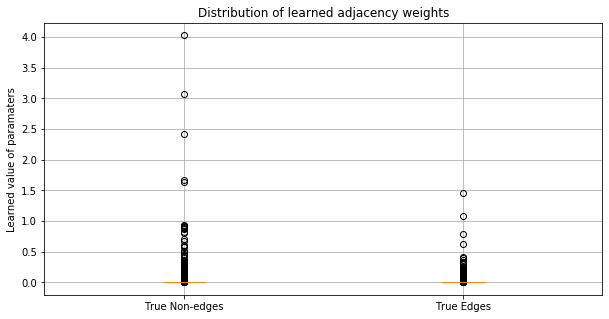

In [40]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.boxplot(
    [adj_hat[adjacency_true == 0.0], adj_hat[adjacency_true > 0.0]],
    labels=['True Non-edges', 'True Edges'])
plt.ylabel(r'Learned value of paramaters')
plt.title('Distribution of learned adjacency weights');

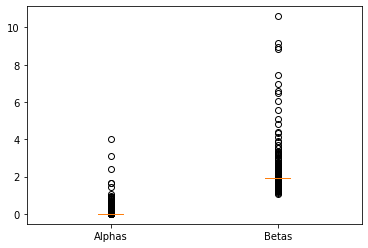

In [42]:
plt.boxplot([adj_hat.flatten(), beta_hat.flatten()], labels=['Alphas', 'Betas']);

---

### Run GB

In [31]:
import gb
import time

dim = len(events)

# Define model
granger_model = gb.GrangerBusca(
    alpha_prior=1.0/len(events),
    num_iter=3000,
    metropolis=True,
    beta_strategy='busca',
    num_jobs=4,
)
granger_model.fit(events)

In [32]:
# Extract infered adjacency
adj_hat = granger_model.Alpha_.toarray()
adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]
beta_hat = np.ones((dim, dim)) * (granger_model.beta_ + 1)
coeffs_hat = np.hstack((granger_model.mu_, beta_hat.flatten(),
                        adj_hat.flatten()))

#adj_hat = adj_hat / beta_hat  # Does not matter


THRESH = 0.00  # GB is already sparse

adj_hat_flat = adj_hat.flatten()
adj_true_flat = adjacency_true.flatten()

acc = tsvar.utils.metrics.accuracy(adj_hat_flat, adj_true_flat, threshold=THRESH)
prec = tsvar.utils.metrics.precision(adj_hat_flat, adj_true_flat, threshold=THRESH)
rec = tsvar.utils.metrics.recall(adj_hat_flat, adj_true_flat, threshold=THRESH)
fsc = tsvar.utils.metrics.fscore(adj_hat_flat, adj_true_flat, threshold=THRESH)
precat5 = tsvar.utils.metrics.precision_at_n(adj_hat_flat, adj_true_flat, n=5)
precat10 = tsvar.utils.metrics.precision_at_n(adj_hat_flat, adj_true_flat, n=10)
precat20 = tsvar.utils.metrics.precision_at_n(adj_hat_flat, adj_true_flat, n=20)

tp = tsvar.utils.metrics.tp(adj_hat_flat, adj_true_flat, threshold=THRESH)
fp = tsvar.utils.metrics.fp(adj_hat_flat, adj_true_flat, threshold=THRESH)
tn = tsvar.utils.metrics.tn(adj_hat_flat, adj_true_flat, threshold=THRESH)
fn = tsvar.utils.metrics.fn(adj_hat_flat, adj_true_flat, threshold=THRESH)


tpr = tsvar.utils.metrics.tpr(adj_hat_flat, adj_true_flat, threshold=THRESH)
fpr = tsvar.utils.metrics.fpr(adj_hat_flat, adj_true_flat, threshold=THRESH)
tnr = tsvar.utils.metrics.tnr(adj_hat_flat, adj_true_flat, threshold=THRESH)
fnr = tsvar.utils.metrics.fnr(adj_hat_flat, adj_true_flat, threshold=THRESH)

print(f"Accuracy: {acc:.2f}")

print()
print('Error types')
print('-----------')
print(f" True Positive: {tp:.2f}")
print(f"False Positive: {fp:.2f}")
print(f" True Negative: {tn:.2f}")
print(f"False Negative: {fn:.2f}")


print()
print('Error rates')
print('-----------')
print(f" True Positive Rate: {tpr:.2f}")
print(f"False Positive Rate: {fpr:.2f}")
print(f" True Negative Rate: {tnr:.2f}")
print(f"False Negative Rate: {fnr:.2f}")

print()
print('F-Score')
print('-------')
print(f" F1-Score: {fsc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"   Recall: {rec:.2f}")

print()
print('Precision@k')
print('-----------')
print(f" Prec@5: {precat5:.2f}")
print(f"Prec@10: {precat10:.2f}")
print(f"Prec@20: {precat20:.2f}")

print()
print('Average Precision@k per node')
print('----------------------------')
print('AvgPrec@k per node:')
for k in [5, 10, 20]:
    print(k, tsvar.utils.metrics.precision_at_n_per_dim(
        A_pred=adj_hat, A_true=adjacency_true, k=k))

Accuracy: 0.26

Error types
-----------
 True Positive: 145.00
False Positive: 330.00
 True Negative: 7047.00
False Negative: 2478.00

Error rates
-----------
 True Positive Rate: 0.06
False Positive Rate: 0.04
 True Negative Rate: 0.96
False Negative Rate: 0.94

F-Score
-------
 F1-Score: 0.09
Precision: 0.31
   Recall: 0.06

Precision@k
-----------
 Prec@5: 0.00
Prec@10: 0.00
Prec@20: 0.00

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.26060606060606045
10 0.25252525252525254
20 0.18333333333333335


In [161]:
tsvar.utils.metrics.relerr(adj_hat.flatten(), adjacency_true.flatten(), null_norm='none')

0.7420330871354197

In [180]:
scipy.stats.kendalltau(adj_hat.flatten(), adjacency_true.flatten())

KendalltauResult(correlation=-0.03233722944985986, pvalue=0.0005001328376041202)

In [166]:
tsvar.utils.metrics.mean_kendall_rank_corr(adj_hat.flatten(), adjacency_true.flatten())

-0.039862506938532154

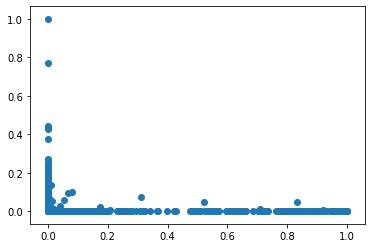

In [167]:
plt.scatter(adj_hat.flatten(), adjacency_true.flatten())

In [181]:
mean_rank_corr, rank_corr_per_dim = tsvar.utils.metrics.mean_kendall_rank_corr(
    adj_hat.flatten(), adjacency_true.flatten(), return_vec=True)

In [182]:
mean_rank_corr

-0.039862506938532154

(array([ 6., 17., 24., 15., 12.,  7.,  8.,  4.,  3.,  4.]),
 array([-0.16471, -0.13208, -0.09946, -0.06683, -0.0342 , -0.00158,  0.03105,  0.06367,  0.0963 ,  0.12893,  0.16155]),
 <a list of 10 Patch objects>)

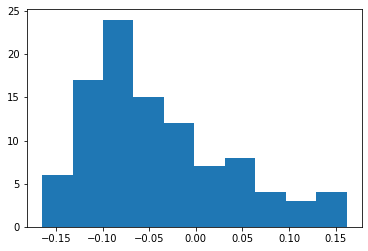

In [183]:
plt.hist(rank_corr_per_dim)

In [172]:
from scipy.stats import kendalltau

# calculate kendall's correlation
coef, p = kendalltau(
    x=adj_hat.flatten(),
    y=adjacency_true.flatten()
)

print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Kendall correlation coefficient: -0.032
Samples are correlated (reject H0) p=0.001


---

## Exploration of results

In [167]:
adj_hat = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]
adj_hat

array([[0.00141, 0.00181, 0.00855, ..., 0.00943, 0.00923, 0.01304],
       [0.00311, 0.00129, 0.01251, ..., 0.00915, 0.00726, 0.01185],
       [0.00343, 0.00186, 0.04852, ..., 0.0099 , 0.00796, 0.01432],
       ...,
       [0.02883, 0.01501, 0.01245, ..., 0.00958, 0.01153, 0.02437],
       [0.01216, 0.00995, 0.00887, ..., 0.03078, 0.01442, 0.02328],
       [0.00137, 0.00276, 0.00194, ..., 0.0191 , 0.01991, 0.01562]])

In [168]:
adj_hat.nonzero()

(array([  0,   0,   0, ..., 622, 622, 622]),
 array([  0,   1,   2, ..., 620, 621, 622]))

In [170]:
adj_hat = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]

thresh_list = np.linspace(0.01, 0.15, 20)

vals_vifb = {
    5: np.zeros_like(thresh_list),
    10: np.zeros_like(thresh_list),
    20: np.zeros_like(thresh_list),
}

for i, thresh in enumerate(thresh_list):

    adj_hat_thresh = adj_hat.copy()
    adj_hat_thresh[adj_hat_thresh < thresh] = 0.0
    print(np.round(thresh, 3), len(adj_hat_thresh.nonzero()[0]))

    for k in [5, 10, 20]:
        vals_vifb[k][i] = tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat_thresh, A_true=adjacency_true, k=k)

0.01 68288
0.017 31004
0.025 17360
0.032 11503
0.039 8389
0.047 6450
0.054 5161
0.062 4092
0.069 3304
0.076 2612
0.084 2068
0.091 1641
0.098 1313
0.106 912
0.113 804
0.121 720
0.128 658
0.135 604
0.143 551
0.15 516


In [159]:
thresh_list = np.linspace(0.01, 0.15, 20)

vals_gb = {
    5: np.zeros_like(thresh_list),
    10: np.zeros_like(thresh_list),
    20: np.zeros_like(thresh_list),
}

for i, thresh in enumerate(thresh_list):

    adj_hat_thresh = adj_hat.copy()
    adj_hat_thresh[adj_hat_thresh < thresh] = 0.0

    for k in [5, 10, 20]:
        vals_gb[k][i] = tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat_thresh, A_true=adjacency_true, k=k)

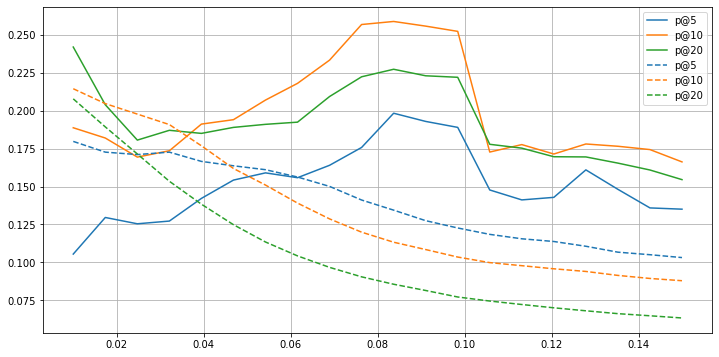

In [161]:
plt.figure(figsize=(12, 6))
plt.grid()

plt.plot(thresh_list, vals_vifb[5], label='p@5')
plt.plot(thresh_list, vals_vifb[10], label='p@10')
plt.plot(thresh_list, vals_vifb[20], label='p@20')

plt.plot(thresh_list, vals_gb[5],   label='p@5', c='C0', ls='--')
plt.plot(thresh_list, vals_gb[10], label='p@10', c='C1', ls='--')
plt.plot(thresh_list, vals_gb[20], label='p@20', c='C2', ls='--')

plt.legend();